In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv(r'D:\Python\MLProjectsPW\CreditCardFraud1\notebooks\data\creditcard.csv')

In [3]:
#separate into independent and dependent features
X = df.drop('Class',axis=1)
y = df['Class']

In [4]:
#rectifying target imbalance
from imblearn.over_sampling import SMOTE
resampler = SMOTE(random_state=42)
X , y = resampler.fit_resample(X, y)

In [5]:
X[y==1].shape , X[y==0].shape

((284315, 30), (284315, 30))

In [6]:
numerical_cols = X.columns
numerical_cols

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [7]:
# since all the features are only numerical in nature creating only numerical pipeline
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [8]:
numerical_pipeline = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline , numerical_cols)
])

In [9]:
## Train test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=30)

In [10]:
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [11]:
X_train.shape , X_test.shape

((398041, 30), (170589, 30))

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import  accuracy_score , roc_auc_score , f1_score

In [42]:
# a function to evaluate the model
def evaluate_model(true, predicted):
    accuracy = accuracy_score(true, predicted)
    roc_score = roc_auc_score(true, predicted)
    f_1_score = f1_score(true, predicted)

    return accuracy , roc_score , f_1_score

In [43]:
models={
    'LogisticRegression':LogisticRegression(),
    'RidgeClassifier':RidgeClassifier(),
    'BernoulliNB':BernoulliNB(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    #'GradientBoostingClassifier':GradientBoostingClassifier(),
    #'BaggingClassifier':BaggingClassifier(),
    #'RandomForestClassifier':RandomForestClassifier(),
    #'SVC':SVC(),
    'XGBClassifier':XGBClassifier()
}
model_list=[]
roc=[]
acc = []
f1 = []
performance = []
for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train,y_train)

    #Make Predictions
    y_pred=model.predict(X_test)

    accuracy , roc_score  , f_1_score =evaluate_model(y_test,y_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    roc.append(roc_score)
    acc.append(accuracy)
    f1.append(f_1_score)
    performance.append((list(models.keys())[i] , accuracy ))


    print('Model Training Performance')
    print("ROC:",roc_score)
    print("Accuracy:",accuracy)

    
    print('='*35)
    print('\n')

print("Best Model" , sorted(performance , key = lambda x: x[1])[-1])
model = models[sorted(performance , key = lambda x: x[1])[-1][0]]
print(model)

metrics = pd.DataFrame({"models": model_list , "accuracy" : acc , "roc_auc_score": roc , "f1_score" : f1}).sort_values('accuracy',ascending=False)
print(metrics)


LogisticRegression
Model Training Performance
ROC: 0.9805037229893587
Accuracy: 0.9805204321497869


RidgeClassifier
Model Training Performance
ROC: 0.93280070681155
Accuracy: 0.9328854732720163


BernoulliNB
Model Training Performance
ROC: 0.9198953725893483
Accuracy: 0.9200065654878099


DecisionTreeClassifier
Model Training Performance
ROC: 0.9983886322867245
Accuracy: 0.9983879382609664


KNeighborsClassifier
Model Training Performance
ROC: 0.9989113002352996
Accuracy: 0.9989096600601446


AdaBoostClassifier
Model Training Performance
ROC: 0.9814312457498023
Accuracy: 0.9814407728517079


XGBClassifier
Model Training Performance
ROC: 0.9997951018152472
Accuracy: 0.9997948285059411


Best Model ('XGBClassifier', 0.9997948285059411)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_ty

In [44]:
metrics

,models,accuracy,roc_auc_score,f1_score
6,XGBClassifier,0.999795,0.999795,0.999795
4,KNeighborsClassifier,0.998910,0.998911,0.998909
3,DecisionTreeClassifier,0.998388,0.998389,0.998386
5,AdaBoostClassifier,0.981441,0.981431,0.981295
0,LogisticRegression,0.980520,0.980504,0.980272
1,RidgeClassifier,0.932885,0.932801,0.928778
2,BernoulliNB,0.920007,0.919895,0.913503


## DEEP LEARNING WITH TF

In [12]:
# splitting X_train to train and validation
X_train , X_val , y_train , y_val = train_test_split(X_train,y_train,test_size=0.3,random_state=30)

In [14]:
X_train.shape , X_val.shape, X_test.shape

((278628, 30), (119413, 30), (170589, 30))

In [15]:
# Importing Libraries
import tensorflow as tf

In [23]:
X_train.iloc[0].shape[0]

30

In [24]:
# Creating layers of ANN
LAYERS = [tf.keras.layers.Flatten(input_shape=[30,], name = 'inputLayer'),
          tf.keras.layers.Dense(300 , activation = 'relu' , name = "hiddenLayer1"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(100 , activation = "relu" , name = 'hiddenLayer2'),
          tf.keras.layers.Dense(10, activation = "relu" , name = "hiddenLayer3"),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(1, activation = "sigmoid" , name = "outputLayer")]
model_clf = tf.keras.models.Sequential(LAYERS)

In [25]:
model_clf.layers

In [26]:
model_clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (Flatten)        (None, 30)                0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               9300      
                                                                 
 batch_normalization_2 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 hiddenLayer3 (Dense)        (None, 10)                1010      
                                                                 
 batch_normalization_3 (Batc  (None, 10)               40        
 hNormalization)                                      

In [27]:
LOSS_FUNCTION = "binary_crossentropy" # use => tf.losses.sparse_categorical_crossentropy
OPTIMIZER = "SGD" # or use with custom learning rate => tf.keras.optimizers.SGD(0.02)
METRICS = ["accuracy"]

model_clf.compile(loss=LOSS_FUNCTION,
                  optimizer=OPTIMIZER,
                  metrics=METRICS)

In [29]:
# training

EPOCHS = 30
VALIDATION_SET = (X_val , y_val)

history = model_clf.fit(X_train , y_train , epochs = EPOCHS,
                        validation_data= VALIDATION_SET , batch_size = 3000)

Epoch 1/30
93/93 [==============================] - 10s 113ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0024 - val_accuracy: 0.9994
Epoch 2/30
93/93 [==============================] - 11s 115ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 3/30
93/93 [==============================] - 8s 87ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 4/30
93/93 [==============================] - 9s 95ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 5/30
93/93 [==============================] - 11s 123ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 6/30
93/93 [==============================] - 11s 115ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 7/30
93/93 [==============================] - 10s 112ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9996
Epo

In [30]:
model_clf.evaluate(X_test,y_test)

5331/5331 [==============================] - 12s 2ms/step - loss: 0.0016 - accuracy: 0.9996


[0.0016471972921863198, 0.9996424317359924]

In [31]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.001799,0.999573,0.002397,0.999422
1,0.001581,0.999659,0.002284,0.999514
2,0.001466,0.999691,0.002200,0.999514
3,0.001393,0.999713,0.002125,0.999498
4,0.001344,0.999731,0.002054,0.999514
5,0.001289,0.999752,0.001996,0.999548
6,0.001255,0.999756,0.001952,0.999556
7,0.001211,0.999777,0.001912,0.999581
8,0.001200,0.999767,0.001877,0.999590
9,0.001167,0.999792,0.001848,0.999590


<Axes: >

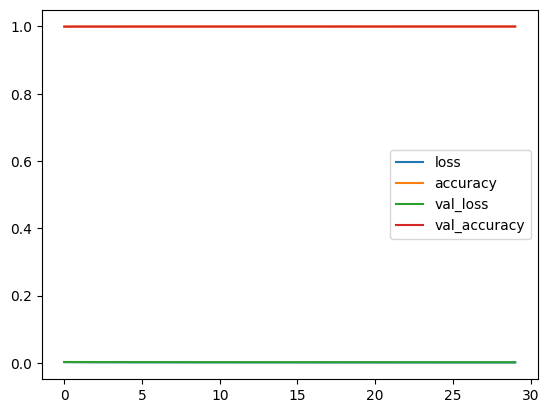

In [32]:
pd.DataFrame(history.history).plot()